In [8]:
import pandas as pd
import numpy as np
import scipy.stats as ss
import pingouin as pg
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf

df = pd.read_csv("1st-dataset-prepressed-baseball.csv")     # 1차 데이터셋

# df = df[df['sports_type'] == "야구"]        # 야구 데이타만 가져옴

pd.set_option("display.max_columns", None)

df['accident_score'] = df['accident_count'] + 3 * df['injury_count']
df.info()

# 분석용 편의 함수
def pct(n): return f"{n:.1%}"

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   game_id         2072 non-null   int64  
 1   stadium_code    2072 non-null   object 
 2   sports_type     2072 non-null   object 
 3   game_date       2072 non-null   object 
 4   day_of_week     2072 non-null   object 
 5   is_holiday      2072 non-null   int64  
 6   start_time      2072 non-null   object 
 7   home_team_win   2072 non-null   int64  
 8   audience        2072 non-null   float64
 9   region          2072 non-null   object 
 10  accident_count  2072 non-null   float64
 11  injury_count    2072 non-null   float64
 12  death_count     2072 non-null   float64
 13  temperature     2072 non-null   float64
 14  precipitation   2072 non-null   float64
 15  snow_depth      2072 non-null   float64
 16  start_hour      2072 non-null   int64  
 17  match_시범경기      2072 non-null   b

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


# X-Columes
x_cols = ['match_정규시즌', 'match_포스트시즌', 'is_holiday', 'start_hour', 'audience'] 

# 1. 독립 변수와 종속 변수 정의
# X = df[x_cols].astype(int)  # bool을 int로 변환
# y = df['accident_count']

# 1. 독립 변수와 종속 변수 정의
X = df.drop(columns=["accident_score", "accident_count", "injury_count", "death_count", "game_id", "stadium_code","sports_type","game_date", "day_of_week", "start_time", "region", "snow_depth"])
y = df['accident_score']

X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2072 entries, 0 to 2071
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   is_holiday     2072 non-null   int64  
 1   home_team_win  2072 non-null   int64  
 2   audience       2072 non-null   float64
 3   temperature    2072 non-null   float64
 4   precipitation  2072 non-null   float64
 5   start_hour     2072 non-null   int64  
 6   match_시범경기     2072 non-null   bool   
 7   match_정규시즌     2072 non-null   bool   
 8   match_포스트시즌    2072 non-null   bool   
dtypes: bool(3), float64(3), int64(3)
memory usage: 103.3 KB


In [11]:
## 포이송 회기 변수 적용
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# 변수 준비: bool → int 변환
df_model = df[['accident_score', 'match_시범경기', 'match_정규시즌', 'match_포스트시즌', 'is_holiday', 'audience', 'start_hour', 'home_team_win', 'temperature', 'precipitation' ]].copy()
df_model['match_시범경기'] = df_model['match_시범경기'].astype(int)
df_model['match_정규시즌'] = df_model['match_정규시즌'].astype(int)
df_model['match_포스트시즌'] = df_model['match_포스트시즌'].astype(int)

# 포아송 회귀모델 정의 (GLM - Generalized Linear Model)
model = smf.glm(
    formula='accident_score ~ match_시범경기 + match_정규시즌 + match_포스트시즌 + is_holiday + start_hour + audience + start_hour + home_team_win + temperature + precipitation',
    data=df_model,
    family=sm.families.Poisson()
)

# 모델 학습
result = model.fit()

# 결과 출력
print(result.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:         accident_score   No. Observations:                 2072
Model:                            GLM   Df Residuals:                     2063
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -27702.
Date:                Thu, 05 Jun 2025   Deviance:                       47227.
Time:                        08:37:44   Pearson chi2:                 4.64e+04
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4913
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.7964      0.055     32.903

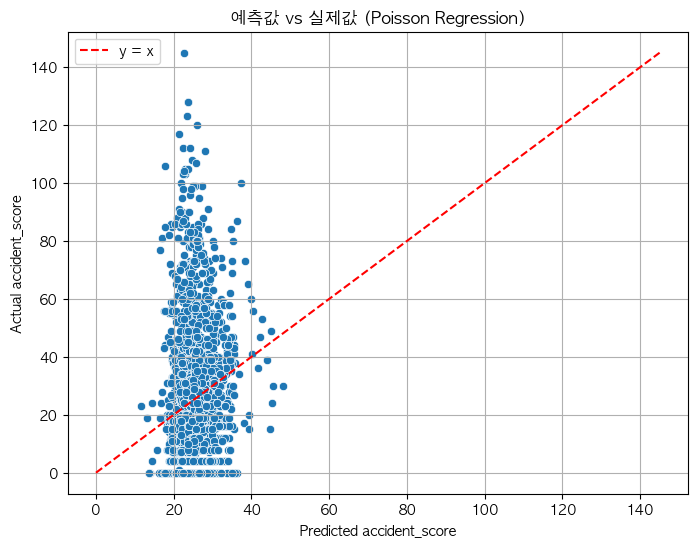

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib as mpl

# 1. 예측값 vs 실제값
df_model['predicted'] = result.predict(df_model)
df_model['residuals'] = df_model['accident_score'] - df_model['predicted']

# Apple 기본 폰트인 'AppleGothic' 사용
mpl.rcParams['font.family'] = 'AppleGothic'
# 음수 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

plt.figure(figsize=(8, 6))
sns.scatterplot(x='predicted', y='accident_score', data=df_model)
plt.plot([df_model['accident_score'].min(), df_model['accident_score'].max()],
         [df_model['accident_score'].min(), df_model['accident_score'].max()],
         'r--', label='y = x')
plt.xlabel('Predicted accident_score')
plt.ylabel('Actual accident_score')
plt.title('예측값 vs 실제값 (Poisson Regression)')
plt.legend()
plt.grid(True)
plt.show()



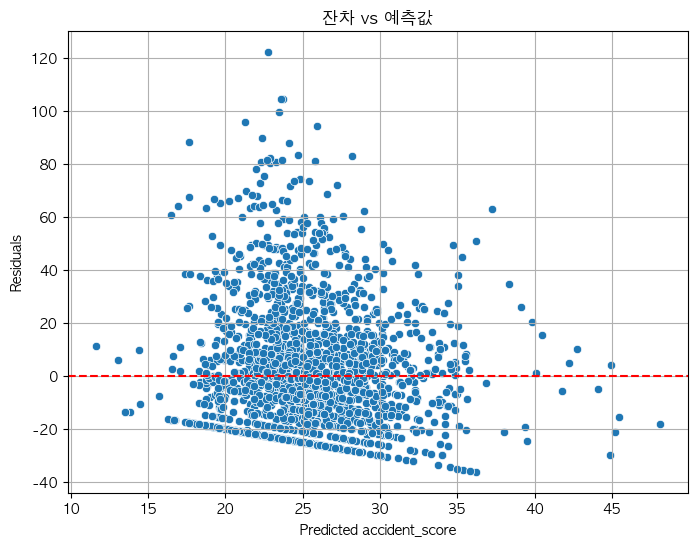

In [18]:
# 2. 잔차 vs 예측값
plt.figure(figsize=(8, 6))
sns.scatterplot(x='predicted', y='residuals', data=df_model)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted accident_score')
plt.ylabel('Residuals')
plt.title('잔차 vs 예측값')
plt.grid(True)
plt.show()

/var/folders/5k/zrsrnd7s18b7z_zm0b5yktj40000gn/T/ipykernel_22983/1024735091.py:9: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=coef_df, y='variable', x='coefficient', join=False)


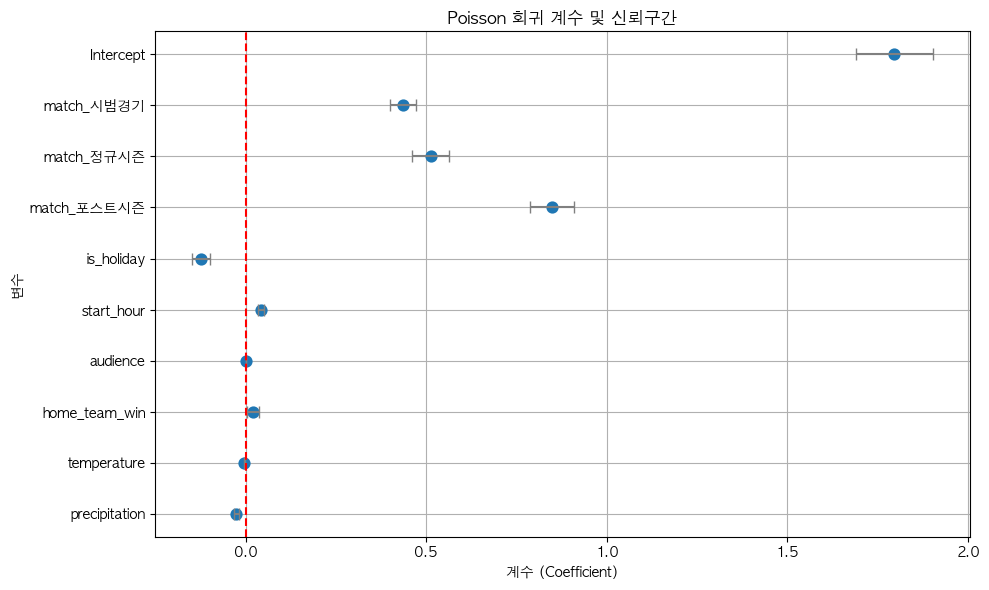

In [19]:
# 3. 계수(Coefficient) 시각화
coef = result.params
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']
coef_df = pd.concat([coef, conf], axis=1).reset_index()
coef_df.columns = ['variable', 'coefficient', 'ci_lower', 'ci_upper']

plt.figure(figsize=(10, 6))
sns.pointplot(data=coef_df, y='variable', x='coefficient', join=False)
plt.errorbar(x=coef_df['coefficient'], y=coef_df['variable'],
             xerr=[coef_df['coefficient'] - coef_df['ci_lower'], coef_df['ci_upper'] - coef_df['coefficient']],
             fmt='none', c='gray', capsize=4)
plt.axvline(0, color='red', linestyle='--')
plt.title('Poisson 회귀 계수 및 신뢰구간')
plt.xlabel('계수 (Coefficient)')
plt.ylabel('변수')
plt.grid(True)
plt.tight_layout()
plt.show()

# 야구경기일 사고위험도 (`accident_score`) 예측: 포아송 회귀 분석 보고서

## 1. 모델 개요

* **목적**: 야구 경기 관련 요인이 **사고 위험 점수(`accident_score`)** 에 유의미한 영향을 주는지 정량적으로 평가
* **모델**: 포아송 회귀 (Generalized Linear Model, `family=Poisson`, `link=log`)
* **종속변수**: `accident_score` (사고 수와 심각도 반영한 지표로 추정)
* **독립변수**:

  * 경기 유형: `match_시범경기`, `match_정규시즌`, `match_포스트시즌`, `audience`, `home_team_win`
  * 시간 및 환경 변수: `start_hour`, `temperature`, `precipitation`
  * 기타 영향 요인: `is_holiday`, 

---

## 2. 모델 적합도

| 항목                 | 값          | 해석                                           |
| ------------------ | ---------- | -------------------------------------------- |
| Log-Likelihood     | -27702     | 모델의 우도 기반 적합도 지표 (높을수록 좋음)                   |
| Deviance           | 47227      | 모델 잔차 제곱합 – 작을수록 적합도 우수                      |
| Pearson chi²       | 4.64e+04   | 데이터의 분산과 잔차 사이의 차이 평가                        |
| **Pseudo R² (CS)** | **0.4913** | 전체 설명력 약 \*\*49.13%\*\*로, 선형회귀 대비 **대폭 향상**됨 |

➡ **결론**: 해당 포아송 모델은 `accident_score` 예측에 있어 **양호한 설명력을 보유**

---

## 3. 주요 계수 해석 (log-link 기반 → exp(β) 해석 가능)

| 변수명                 | 계수 (β)   | P-value | 해석 요약                                             |
| ------------------- | -------- | ------- | ------------------------------------------------- |
| **Intercept**       | 1.796    | 0.000   | 기준 조건에서 사고점수 log값이 1.796 → exp(1.796) ≈ **6.03점** |
| **match\_시범경기**     | 0.436    | 0.000   | 시범경기는 기준 대비 **exp(0.436) ≈ 1.55배 위험도 증가**         |
| **match\_정규시즌**     | 0.513    | 0.000   | 정규시즌 경기일 경우 **약 1.67배 증가**                        |
| **match\_포스트시즌**    | 0.847    | 0.000   | 포스트시즌일 경우 **약 2.33배 증가** (가장 큰 영향)                |
| **is\_holiday**     | -0.123   | 0.000   | 공휴일은 사고점수 **약 12% 감소** (exp(-0.123) ≈ 0.88)       |
| **start\_hour**     | 0.042    | 0.000   | 경기 시작 시간 1시간 증가 시 **4.3% 증가**                     |
| **audience**        | 2.45e-05 | 0.000   | 관중 수 증가 → 위험도 비례 증가 (10,000명당 약 27.6% 증가)         |
| **home\_team\_win** | 0.0208   | 0.018   | 승리 시 약간 증가 (약 2.1%) – 미미하지만 유의                    |
| **temperature**     | -0.0043  | 0.000   | 기온 1도 상승 시 사고점수 약 0.4% 감소                         |
| **precipitation**   | -0.0255  | 0.000   | 강수량 증가 시 사고점수 약 2.5% 감소                           |

➡ **핵심 해석**:

* 포스트시즌이 가장 큰 위험도 증가 요인
* 공휴일, 기온, 강수는 위험도를 줄이는 요인
* 관중 수와 시작 시간이 높을수록 위험도 상승

---

## 4. 모델 특이점 및 비교

| 항목       | 선형회귀   | 포아송회귀                       |
| -------- | ------ | --------------------------- |
| 설명력 (R²) | 3% 내외  | **49.1%** (대폭 향상)           |
| 유의 변수 수  | 일부만    | **모든 변수 통계적으로 유의**          |
| 해석 방식    | 절대 증가량 | **비율(%) 기반 해석** 가능 (exp(β)) |

➡ **포아송 회귀는 `accident_score` 같은 이산적/비선형 지표 예측에 더 적합**

---

## 5. 결론 및 제언

### 🎯 핵심 결론

* 포스트시즌 경기, 관중 수, 경기 시작 시각이 **사고 위험도 증가 요인**
* 공휴일, 기온, 강수는 **사고 위험도 감소 요인**
* 모델의 설명력 및 예측 적합도는 **선형회귀에 비해 월등히 우수**

### ✅ 향후 제언

1. **모델 활용성 확대**:

   * 사고 예방 캠페인, 교통 통제 계획, 관중 수 제한 정책 등에 활용 가능

2. **데이터 확장**:

   * 지역 기반 변수, 경기장 별 인프라, 요일 등 추가시 더 높은 정확도 기대

3. **모델 정교화**:

   * Zero-Inflated Poisson (ZIP), Negative Binomial 등도 향후 적용 고려


